# Gaussian Process

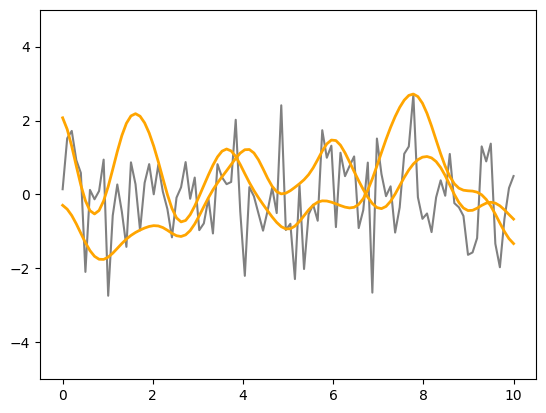

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def exp_quad_kernel(x1: float, x2: float, length=0.5):
    return np.exp(-(x1 - x2)**2 / (2 * length**2))

def covariance(x1: np.ndarray, x2: np.ndarray, kernel=exp_quad_kernel):
    assert type(x1) == np.ndarray, type(x2) == np.ndarray
    if len(x1) == len(x2):
        dim = len(x1)
        g1, g2 = np.meshgrid(x, x)
        g1 = g1.reshape(dim * dim,)
        g2 = g2.reshape(dim * dim,)
        cov = kernel(g1, g2)
        return cov.reshape(dim, dim)
    else:
        return kernel(x1, x2)

x = np.linspace(0, 10, 100)

f_norm = stats.norm.rvs(loc=0, scale=1, size=100)
plt.plot(x, f_norm, color='gray')

cov = covariance(x, x)
f_mvn = stats.multivariate_normal.rvs(mean=np.zeros(len(x)), cov=cov, size=2).T

plt.plot(x, f_mvn, color="orange", linewidth=2)
plt.ylim([-5, 5])

plt.show()


In [26]:
from numpy.linalg import inv

def sample(x_new, x, y):
    """Sample y_new from a conditional probability p(y_new|x_new, x, y)"""
    K = covariance(x, x)
    k = covariance(x_new, x)
    kss = exp_quad_kernel(x_new, x_new)

    mu = k.T @ inv(K) @ y
    sigma = kss - k.T @ inv(K) @ k
    return stats.norm.rvs(mu, sigma)

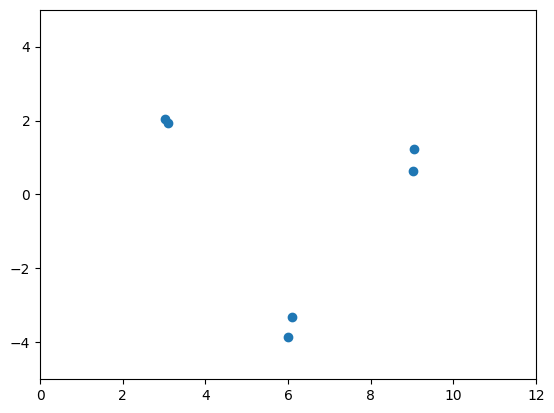

In [29]:
x3 = 3 + stats.norm.rvs(loc=0, scale=0.1, size=2)
y3 = stats.norm.rvs(loc=2, scale=1, size=len(x3))

x6 = 6 + stats.norm.rvs(loc=0, scale=0.1, size=2)
y6 = stats.norm.rvs(loc=-3, scale=1, size=len(x6))

x9 = 9 + stats.norm.rvs(loc=0, scale=0.1, size=2)
y9 = stats.norm.rvs(loc=1, scale=1, size=len(x9))

x = np.hstack([x3, x6, x9])
y = np.hstack([y3, y6, y9])

plt.scatter(x, y)

plt.xlim([0, 12])
plt.ylim([-5, 5])

plt.show()

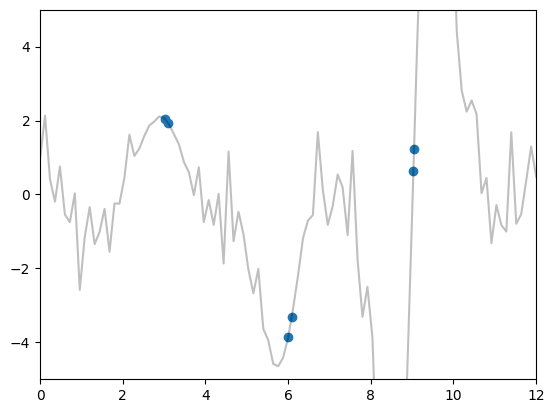

In [30]:
xs = np.linspace(0, 12, 101)
fs = []

for x_new in xs:
    x_new = np.array([x_new])
    y_new = sample(x_new, x, y)
    fs.append(y_new)

plt.plot(xs, fs, c='k', alpha=0.25)

plt.scatter(x, y)

plt.xlim([0, 12])
plt.ylim([-5, 5])

plt.show()


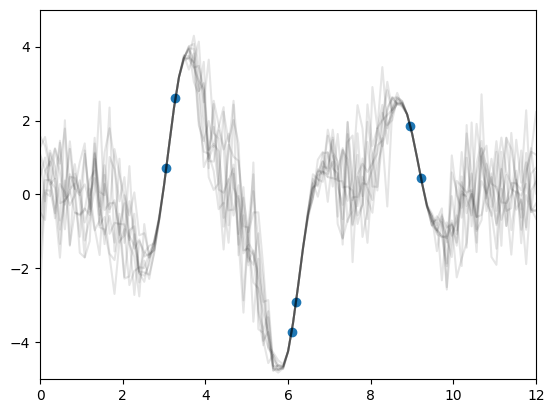

In [5]:
from numpy.linalg import inv

for i in range(10):
    xs = np.linspace(0, 12, 101)
    fs = []
    for x_new in xs:
        x_new = np.array([x_new])
        K = covariance(x, x)
        k = covariance(x_new, x)
        kss = exp_quad_kernel(x_new, x_new)

        mu = k.T @ inv(K) @ y
        sigma = kss - k.T @ inv(K) @ k
        fs.append(stats.norm.rvs(mu, sigma))

    plt.plot(xs, fs, c='k', alpha=0.1)

plt.scatter(x, y)

plt.xlim([0, 12])
plt.ylim([-5, 5])

plt.show()


# Gaussian Process with NumPyro

In [41]:
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import  MCMC, NUTS

N = 30
# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X  + 1 * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test


X, Y, X_test = get_data(N)

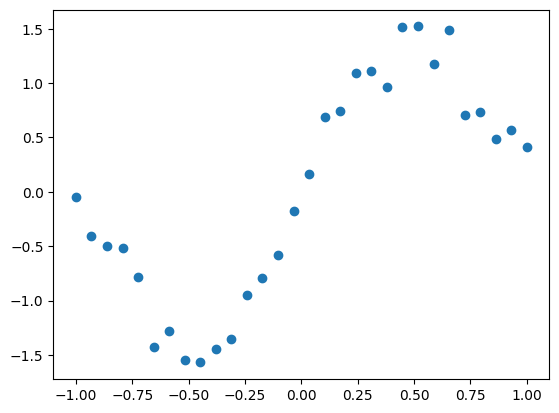

In [42]:
x_ = jnp.linspace(-1, 1, 100)
y_ = x_ + 0.5 * jnp.sin(4.0 * x_)
#plt.plot(x_, y_, c="gray")

plt.scatter(X, Y)
plt.show()

In [43]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k), obs=Y)

In [44]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
sampler = NUTS(model)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, progress_bar=True)
mcmc.run(rng_key, X, Y)

samples = mcmc.get_samples()

mcmc.print_summary()
#                    mean       std    median      5.0%     95.0%     n_eff     r_hat
# kernel_length      0.55      0.14      0.55      0.32      0.74    477.61      1.00
#  kernel_noise      0.06      0.02      0.05      0.03      0.08    611.13      1.00
#    kernel_var      2.07      4.48      1.07      0.13      3.92    383.80      1.00

sample: 100%|██████████| 2000/2000 [00:02<00:00, 783.66it/s, 7 steps of size 4.36e-01. acc. prob=0.93]  


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.47      0.10      0.46      0.31      0.64    422.13      1.01
   kernel_noise      0.03      0.01      0.03      0.02      0.04    662.56      1.00
     kernel_var      2.11      3.68      1.19      0.23      3.84    195.26      1.00

Number of divergences: 0


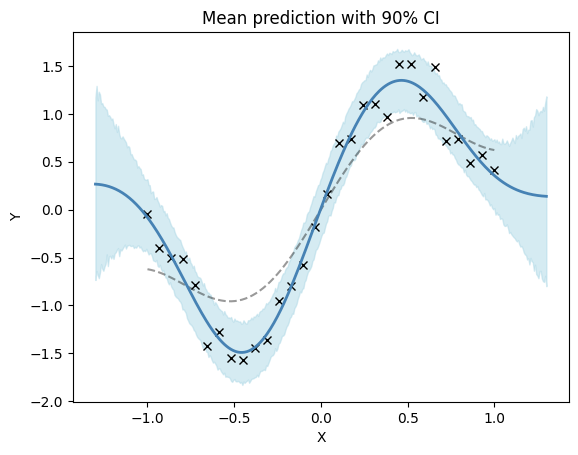

In [45]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise



keys = random.split(rng_key_predict, samples["kernel_var"].shape[0])
vars = samples["kernel_var"]
lengths = samples["kernel_length"]
noises = samples["kernel_noise"]

means, predictions = vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(keys, vars, lengths, noises)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

plt.plot(x_, y_, c='k', ls="dashed", alpha=0.4)
plt.plot(X, Y, "kx")
plt.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.5)
plt.plot(X_test, mean_prediction, c="steelblue", ls="solid", lw=2.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Mean prediction with 90% CI")


plt.show()


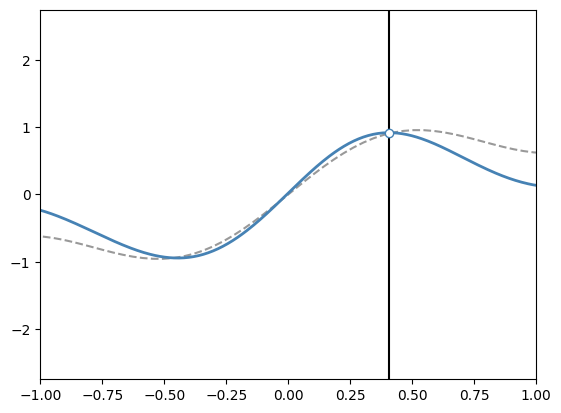

In [18]:
import numpy as np

def acquire(X, Y, X_test, vars, lengths, noises) -> (int, float):
    idx = np.random.randint(0, vars.shape[0])
    f_mean, predictions = predict(random.PRNGKey(0), X, Y, X_test, vars[idx], lengths[idx], noises[idx])
    x_idx = np.argmax(f_mean)

    return x_idx, X_test[x_idx], f_mean

x_idx, x_star, f_mean = acquire(X, Y, X_test, vars, lengths, noises)
y_star = f_mean[x_idx]

plt.plot(x_, y_, c='k', ls="dashed", alpha=0.4)
plt.plot(X_test, f_mean, c="steelblue", ls="solid", lw=2.0)
plt.axvline(x=x_star, c='k')

plt.plot(x_star, y_star, marker="o", markersize=6, markeredgecolor="steelblue", markerfacecolor="white")

plt.xlim([-1, 1])
plt.show()